In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
sns.set()


def isNewContainer(containerId):
    if containerId in knownIds:
        return "Reused"
    knownIds[containerId] = True
    return "New"

def percentile(n):
    def percentile_(x):
        return np.nanpercentile(x, n)
    percentile_.__name__ = 'p_%s' % n
    return percentile_

#constants
experiment_phase = {'p0':60000, 'p1':60000, 'p2':180000}

labels = {
    "ibm": {
        "name": "ICF",
        "color": "cyan",
        "colorB": "darkcyan",
        "y-lim":5
    },
    "aws": {
        "name": "AWS",
        "color": "darkorange",
        "colorB": "brown",
        "y-lim":5
    },
    "gcf": {
        "name": "GCF",
        "color": "red",
        "colorB": "darkred",
        "y-lim":20
    },
    "azure": {
        "name": "MAF",
        "color": "blue",
        "colorB": "darkblue",
        "y-lim":200
    }
}

# Reading the results

In [23]:
#config
experiment_name = "test_180"
providers = ["ibm","aws", "gcf", "azure"] 
num_repetitions = 1
configs = ["0,0,1"]#,"0,0,2","0,0,0.5","60,60,1","60,60,2","60,60,0.5"]
experiment_phase_labels = [*experiment_phase]


In [46]:

knownIds = {}
all = None
for config in configs:
    for provider in providers:
        for run in range(1, num_repetitions+1):
            try:
                df = pd.read_csv('results/'+experiment_name+'/'+config+'/'+str(run)+'/'+provider+'.csv', skiprows = 0)

                df['provider'] = provider
                df['run'] = run
                df['config'] = config

                
                startTime = df['requestTime'].min()                
                if config[0] == "0":
                    startTime-=experiment_phase_length
                df['m1'] = df['requestTime']-startTime
                df['m2'] = df['executionStartTime']-startTime
                df['m3'] = df['executionEndTime']-startTime
                df['m4'] = df['responseTime']-startTime

                df['deliveryLatency']= (df['m2']-df['m1']) / 1000
                df['requestResponseLatency'] = df['requestResponseLatency'] / 1000
                df['executionLatency'] = df['executionLatency'] / 1000
                df['requestTime_normalized'] = df['requestTime'] - startTime
                df['requestTime_per30sec'] = df['requestTime_normalized'] // 30000 * 30
                df['requestTime_per5sec'] = df['requestTime_normalized'] // 100 / 10
                df['executionStartTime_normalized'] = df['executionStartTime'] - startTime
                df['experimentTime'] = df['requestTime_normalized'] // 1000
                df['executionStartTime_per30sec'] = df['executionStartTime_normalized'] // 30000 * 30
                df['executionStartTime_per5sec'] = df['executionStartTime_normalized'] // 100 / 10
                df['nonExecutionLatency'] = df['requestResponseLatency'] - df['executionLatency']
                df['label'] = 'none'
                interval_start = 0
                for name in experiment_phase_labels:
                    interval_lenght = experiment_phase[name]
                    df.loc[df['m1'].between(interval_start,interval_start+interval_lenght),'label'] =name
                    interval_start += interval_lenght
                   
                
                
                df['newContainer'] = df['containerId'].apply(isNewContainer)
                df['failed'] = df['statusCode'] > 400

                df['executionLatencyNormalized'] = (df['executionLatency'] - df['executionLatency'].mean()) / df['executionLatency'].std()
                if (all is None):
                    all = df
                else:
                    all = pd.concat([all, df], sort=True)
            except OSError as e:
                print("Failed to read file for",provider,config,run)

all.head()



,config,containerId,containerStartTime,deliveryLatency,executionEndTime,executionLatency,executionLatencyNormalized,executionStartTime,executionStartTime_normalized,executionStartTime_per30sec,...,requestResponseLatency,requestTime,requestTime_normalized,requestTime_per30sec,requestTime_per5sec,responseTime,result,run,statusCode,vmId
0,"0,0,1",6472890.0,1.567607e+12,1.207,1.567607e+12,1.188,-2.219456,1.567607e+12,61207.0,60.0,...,2.468,1567607018276,60000,60,60.0,1567607020744,False,1,200,1ELQPGI
1,"0,0,1",6454157.0,1.567607e+12,0.902,1.567607e+12,1.253,-2.093901,1.567607e+12,62028.0,60.0,...,2.205,1567607019402,61126,60,61.1,1567607021607,False,1,200,1ELQPGI
2,"0,0,1",8027923.0,1.567607e+12,1.198,1.567607e+12,1.293,-2.016637,1.567607e+12,62684.0,60.0,...,2.569,1567607019762,61486,60,61.4,1567607022331,False,1,200,1ELQPGJ
3,"0,0,1",2762123.0,1.567607e+12,1.027,1.567607e+12,1.450,-1.713373,1.567607e+12,62666.0,60.0,...,2.525,1567607019915,61639,60,61.6,1567607022440,False,1,200,1ELQPGJ
4,"0,0,1",6472890.0,1.567607e+12,0.247,1.567607e+12,1.267,-2.066859,1.567607e+12,62902.0,60.0,...,1.558,1567607020931,62655,60,62.6,1567607022489,False,1,200,1ELQPGI


In [47]:
all['label'].unique()

array(['p1', 'p2'], dtype=object)

### Thrughput

In [49]:
phase_time = experiment_phase
rows=["provider","phase","mean thr","target thr","relative thr???"]
colm = []
provider="gcf"
run = 2
for provider in providers:
    data = all[all['provider'] == provider]
    data = data[data['failed'] == False]
#     data = data[data["run"]==2]
    for phase in experiment_phase_labels:
        window = data[data["label"]==phase]
        lastSendInPhase=phase_time[phase]
        thr_mean = window[window['m4'] < lastSendInPhase]["m4"].count()/60.0/num_repetitions
        thr_target = window['m1'].count()/60.0/num_repetitions
        colm.append([provider,phase,"%.1f" %thr_mean,"%.1f" %thr_target,"%.1f" %((thr_mean*100)/thr_target)])
    
thr_qualities = pd.DataFrame(colm,columns=rows)
with open('./reports/thr_per_phase.csv',"w") as f:
    f.write(thr_qualities.to_csv())
thr_qualities

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


,provider,phase,mean thr,target thr,relative thr???
0,ibm,p0,0.0,0.0,nan
1,ibm,p1,0.0,31.4,0.0
2,ibm,p2,57.4,179.6,31.9
3,aws,p0,0.0,0.0,nan
4,aws,p1,0.0,30.9,0.0
5,aws,p2,58.3,179.6,32.5
6,gcf,p0,0.0,0.0,nan
7,gcf,p1,0.0,29.7,0.0
8,gcf,p2,58.4,179.9,32.5
9,azure,p0,0.0,0.0,nan


### Performance

In [50]:

rows=["provider","phase","median","90%","99%","max"]
colm = []
for provider in providers:
    data = all[all['provider'] == provider]
    data = data[data['failed'] == False]
#     data = data[data["run"]==2]
    for phase in experiment_phase_labels:
        window = data[data["label"]==phase]
        lastSendInPhase=phase_time[phase]
        window=window[window['m1'] < lastSendInPhase]['requestResponseLatency']
        colm.append([provider,phase,"%.2f" %window.quantile(0.5),"%.2f" %window.quantile(0.9),"%.2f" %window.quantile(0.99),"%.2f" %window.max()])
    
perf_qualities = pd.DataFrame(colm,columns=rows)
perf_qualities
with open('./reports/perf_per_phase.csv',"w") as f:
    f.write(perf_qualities.to_csv())
perf_qualities

,provider,phase,median,90%,99%,max
0,ibm,p0,nan,nan,nan,nan
1,ibm,p1,nan,nan,nan,nan
2,ibm,p2,2.68,3.31,4.52,7.43
3,aws,p0,nan,nan,nan,nan
4,aws,p1,nan,nan,nan,nan
5,aws,p2,1.72,1.76,1.84,2.27
6,gcf,p0,nan,nan,nan,nan
7,gcf,p1,nan,nan,nan,nan
8,gcf,p2,8.35,20.30,23.78,39.78
9,azure,p0,nan,nan,nan,nan


### Exec and NonExec Lat 

In [51]:
data = all
data = data[data['failed'] == False]
window =  data[['provider','label','nonExecutionLatency','executionLatency','deliveryLatency','newContainer']]
window['label']=window['label'].apply(lambda x: "phase %d"%(experiment_phase_labels.index(x)))
def _max(n):
    return np.max(n)
_max.__name__ = "max"
def _size(n):
    return len(n)
_size.__name__= "req. [#]"
foo = window.groupby(['provider','label','newContainer'])
exec_nonexec_lat = foo.agg([percentile(90), percentile(99),_max])
exec_nonexec_lat["req. [#]"] = foo["nonExecutionLatency"].agg([_size])
with open('./reports/container_exec_nonexec_per_phase.csv',"w") as f:
    f.write(exec_nonexec_lat.to_csv())

style_map = exec_nonexec_lat.columns.get_loc_level('p_90', level=1)[0] | exec_nonexec_lat.columns.get_loc_level('p_99', level=1)[0] | exec_nonexec_lat.columns.get_loc_level('max', level=1)[0] 

cm = sns.light_palette("green", as_cmap=True)

exec_nonexec_lat.style.format("{:.2f}",subset=style_map)


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Failed Requests

In [52]:
data = all
window =  data[['provider','label','failed']]
w = window.groupby(['provider','label','failed'])
w = w['failed'].count().reset_index(name="#")
total = w.groupby(['provider','label'])["#"].sum().reset_index(name="total")
def get(x):
    return int(total[(total['provider'] ==x['provider']) & (total['label'] == x['label'])].total)
w["failed req. [%]"] = w.apply(lambda x: x["#"]/get(x),axis=1)

with open('./reports/failed_req.csv',"w") as f:
    f.write(w[w['failed']==True][["provider",'label',"failed req. [%]"]].to_csv())
failed_req = w
w[w['failed']==True][["provider",'label',"failed req. [%]"]]

,provider,label,failed req. [%]
3,azure,p1,0.615506
5,azure,p2,0.538576
7,gcf,p1,0.002238


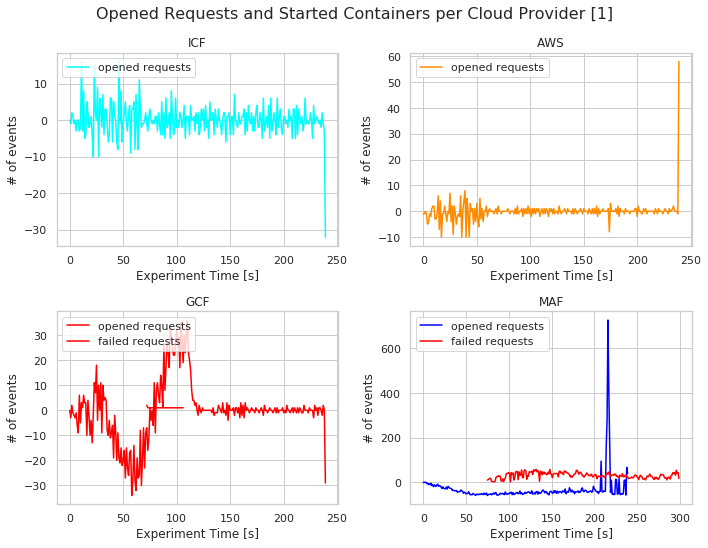

In [53]:

for run in range(1,num_repetitions+1):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10.0, 8.0))
    plt.suptitle("Opened Requests and Started Containers per Cloud Provider [%d]"%run, fontsize=16)
    #plt.subplot(221)
    #ax = sns.boxplot(x="requestTime_per30sec", hue="provider", y="requestResponseLatency", data=all, palette="Set3", )
    #ax2 =  ax.twinx()
    #plt.subplot(412)
    plotId = 221
    for provider in providers:
        plt.subplot(plotId)
        plotId += 1
        data = all[all['provider'] == provider]
        data = data[data["run"]==run]
        data = data.sort_values(by="m1")
        data['m1_bucket']=round(data['m1']/1000)
        data['m2_bucket']=round(data['m2']/1000)
        A = data.groupby('m1_bucket')['m1'].count().reset_index(name='c')
    #     ax = sns.lineplot(x='m1_bucket', y='c', data=A, color=labels[provider]["color"], markers=True)
        B = data.groupby('m2_bucket')['m2'].count().reset_index(name='c')
    #     sns.lineplot(x='m2_bucket', y='c', data=B, color=labels[provider]["colorB"], markers=True)
        X = B.rename(columns={"m2_bucket":"x"})['c']-A.rename(columns={"m1_bucket":"x"})['c']
        X = X[0:360]
        ax = sns.lineplot( data=X, color=labels[provider]["color"], markers=True)

        failedExecutions = data[data['statusCode'] >= 400]
        C = failedExecutions.groupby('m1_bucket').size().reset_index(name='counts')
    #     failedExecutions = failedExecutions[['requestTime_per5sec', 'requestTime_normalized']].groupby(['requestTime_per5sec']).count().reset_index()
    #     failedExecutions['failures'] = failedExecutions['requestTime_normalized'].rolling(20, min_periods=1).mean() * 10
        sns.lineplot(x='m1_bucket', y='counts', data=C, color='red', markers=True)

        ax.legend(["opened requests", "failed requests"], loc='upper left')
    #     ax.set_xlim([0,380])
    #     ax.set_ylim([0,140])
        ax.set(xlabel='Experiment Time [s]', ylabel='# of events', title=labels[provider]["name"])


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

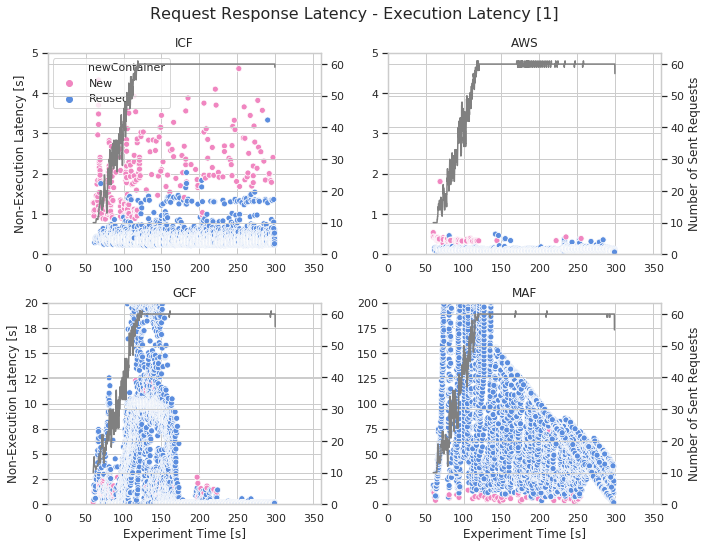

In [54]:
for run in range(1,num_repetitions+1):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10.0, 8.0))
    plt.suptitle("Request Response Latency - Execution Latency [%d]"%run, fontsize=16)


    plotId = 221
    plot = 0
    for provider in providers:
        plt.subplot(plotId)
        plotId += 1
        plot+=1
        data = all[all["provider"] == provider]
        data = data[data["run"] == run]

        ax = sns.scatterplot(x="experimentTime", y="nonExecutionLatency", data = data, palette = {"New":"#f086c0","Reused":"#5b8dde"}, hue="newContainer")

        requestsPerSecond = data[['requestTime_per5sec', 'requestTime_normalized']].groupby(['requestTime_per5sec']).count().reset_index()
        requestsPerSecond['startedRequests'] = requestsPerSecond['requestTime_normalized'].rolling(10, min_periods=1).mean() * 10
        ax2 = ax.twinx()
        sns.lineplot(x='requestTime_per5sec', y='startedRequests', data=requestsPerSecond, color="gray", markers=True)

        ax.set_ylim(bottom=0,top=labels[provider]["y-lim"])
        ax.set_xlim(left=0, right=360)

        if plot == 1:
            ax.legend(loc='upper left')
        else:
            ax.get_legend().remove()

        ax2.set_ylim(bottom=0)
        ax2.set_xlim(left=0)

        if plot > 2:
            ax.set(xlabel='Experiment Time [s]', title=labels[provider]["name"])
        else:
            ax.set(xlabel='', title=labels[provider]["name"])

        if plot%2 ==1:
            ax.set(ylabel='Non-Execution Latency [s]')
            ax2.set(ylabel='')
        else:
            ax.set(ylabel='')
            ax2.set(ylabel='Number of Sent Requests')
        ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: "{0:.0f}".format(x)))    



    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

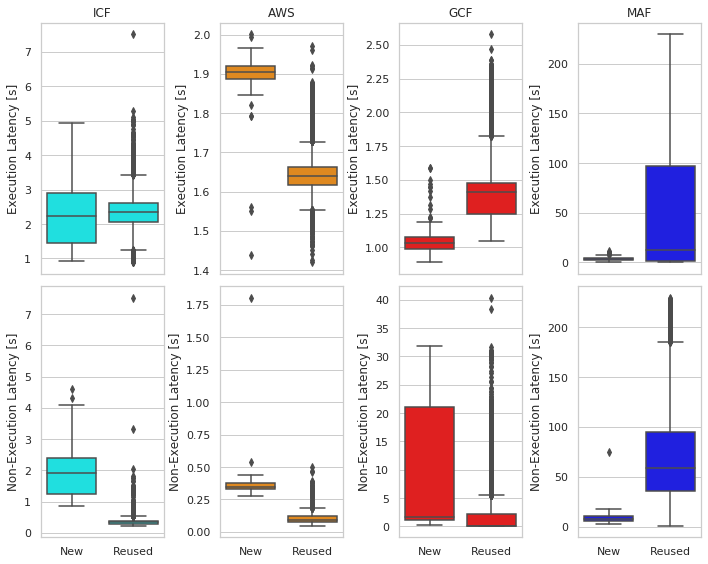

In [56]:
plt.figure(figsize=(10,8))
pltId = 1
for provider in providers:
    plt.subplot(2, 4, pltId)
    data = all[all["provider"] == provider]
    ax = sns.boxplot(x="newContainer", y="executionLatency", color=labels[provider]["color"], data = data)
    ax.set(ylabel='Execution Latency [s]', xlabel="", title=labels[provider]["name"])
    ax.get_xaxis().set_ticks([])
    plt.subplot(2, 4, pltId+4)
    ax2 = sns.boxplot(x="newContainer", y="nonExecutionLatency", color=labels[provider]["color"], data = data)
    pltId += 1
    ax2.set(ylabel='Non-Execution Latency [s]', xlabel="")
    ax2.get_xaxis().labelpad = 20
plt.tight_layout()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

plt.savefig("./reports/Container1.pdf")

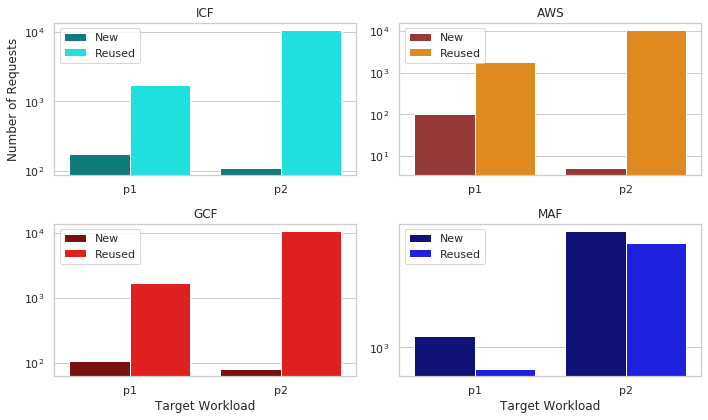

In [58]:
plt.figure(figsize=(10,6))
pltId = 1
for provider in providers:
    plt.subplot(2, 2, pltId)
    ax = sns.countplot(x="label", hue="newContainer", data = all[all["provider"] == provider], palette=[labels[provider]["colorB"], labels[provider]["color"]])
    #ax.set_ylim(0, 18000)
    ax.set_yscale("log")
    ax.set(title=labels[provider]["name"])
    if pltId == 1:
        ax.set(ylabel="Number of Requests", xlabel="")
    elif pltId >= 3:
        ax.set(ylabel="", xlabel="Target Workload")
    else:
        #ax.get_yaxis().set_ticks([])
        ax.set(ylabel="", xlabel="")
    pltId += 1
    ax.legend(["New", "Reused"], loc='upper left')

plt.tight_layout()
plt.savefig("./reports/Container2.pdf")